## Throughput Graph

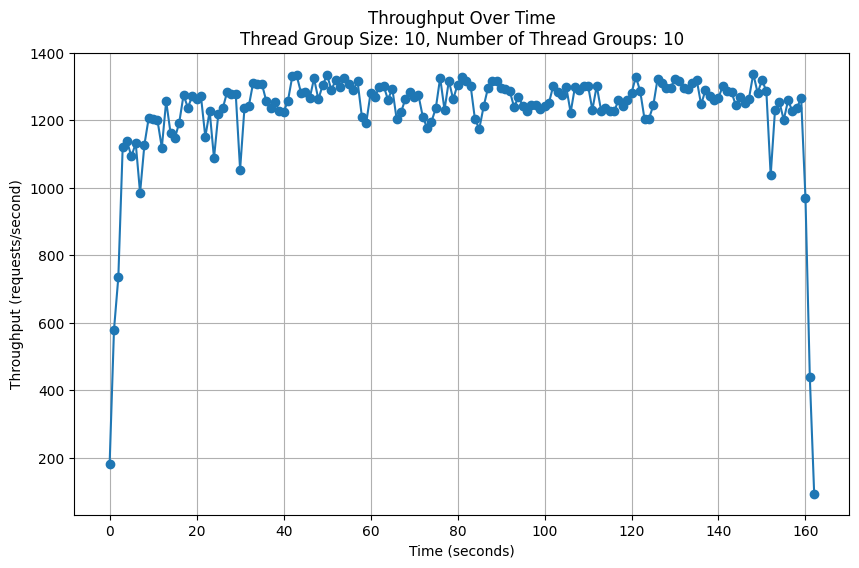

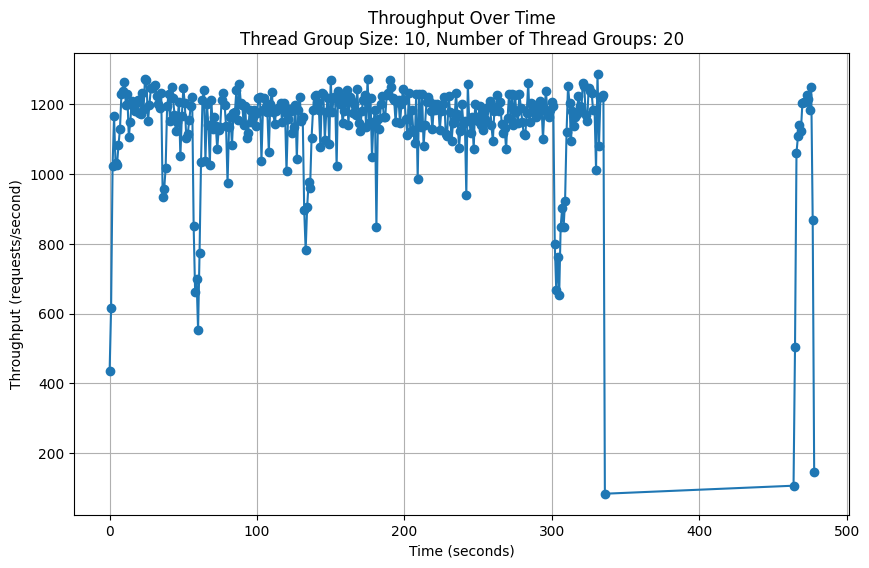

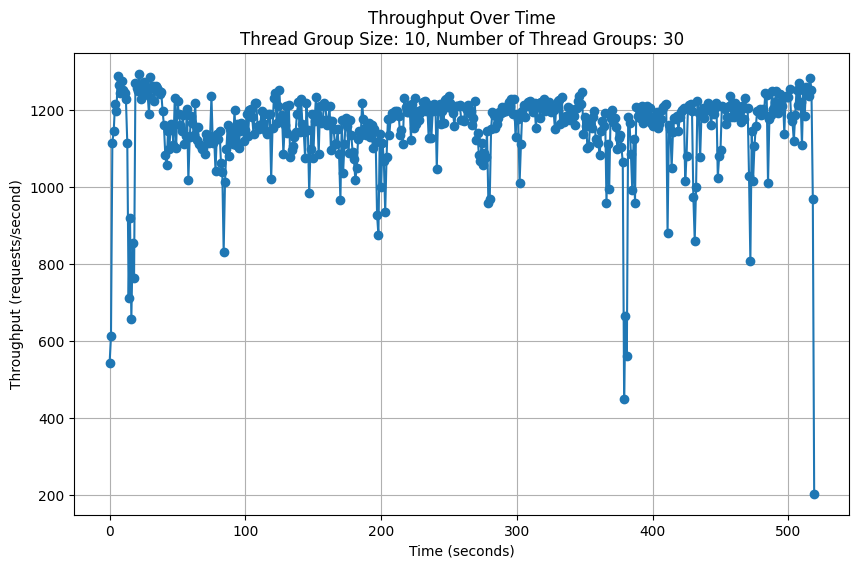

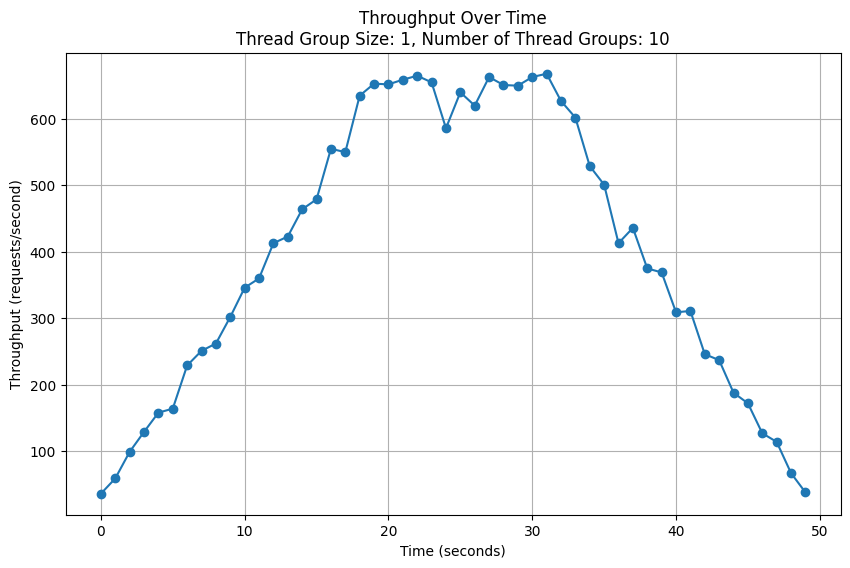

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import re

# Get all CSV files matching the pattern "response_time_size-*_*.csv" in the current folder
csv_files = glob.glob('response_time_size-*_*.csv')

# Initialize an empty list to hold all the data
all_data = []

# Load each CSV file and append the data to the list
for csv_file in csv_files:
    data = pd.read_csv(csv_file)
    all_data.append((csv_file, data))

# Check if there are any CSV files to process
if all_data:
    for csv_file, data in all_data:
        # Extract threadGroupSize and numThreadGroups from the file name
        match = re.search(r'response_time_size-(\d+)_(\d+)_groups\.csv', csv_file)
        if match:
            threadGroupSize = match.group(1)
            numThreadGroups = match.group(2)

            # Convert start_time from milliseconds to seconds
            data['start_time'] = data['start_time'] // 1000

            # Calculate the throughput per second
            throughput = data.groupby('start_time').size()

            # Plot the graph
            plt.figure(figsize=(10, 6))
            plt.plot(throughput.index - throughput.index.min(), throughput.values, marker='o')
            plt.xlabel('Time (seconds)')
            plt.ylabel('Throughput (requests/second)')
            plt.title(f'Throughput Over Time\nThread Group Size: {threadGroupSize}, Number of Thread Groups: {numThreadGroups}')
            plt.grid(True)
            plt.show()
else:
    print("No CSV files found matching the pattern 'response_time_size-*_*.csv'")

## Throughput Graph Using Client Data (don't use)

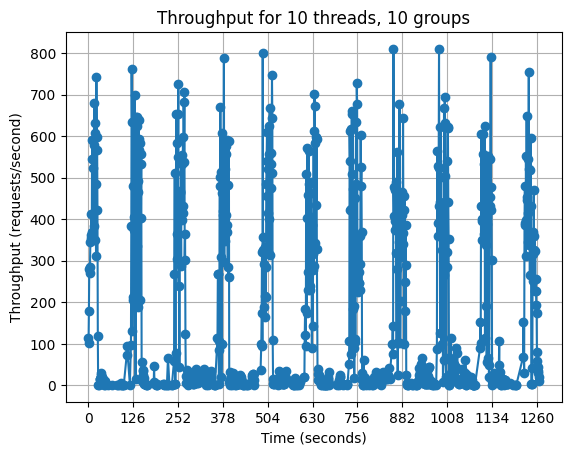

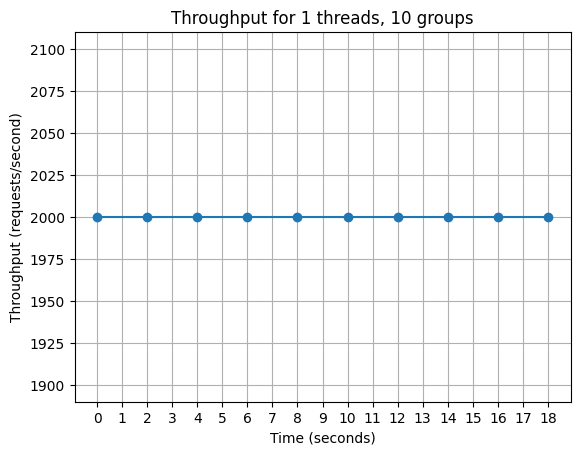

In [2]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt

# Define regex pattern to match files
pattern = re.compile(r"throughput_size-(\d+)_(\d+)_groups\.csv")

# Get all matching files in the current directory
files = [f for f in os.listdir(".") if pattern.match(f)]

for file in files:
    # Extract threadGroupSize and numThreadGroups from filename
    match = pattern.match(file)
    if match:
        thread_group_size, num_thread_groups = map(int, match.groups())

        # Read the CSV file
        df = pd.read_csv(file)

        # Ensure the 'second' column is read as integers
        df['second'] = pd.to_numeric(df['second'], errors='coerce').fillna(0).astype(int)

        # Filter out large values in the 'second' column
        df = df[df['second'] < 10000]

        # Create a new figure for each file
        plt.figure()
        plt.plot(df["second"], df["requests_completed"], marker="o")
        plt.xlabel("Time (seconds)")
        plt.ylabel("Throughput (requests/second)")
        plt.title(f"Throughput for {thread_group_size} threads, {num_thread_groups} groups")
        max_time = df["second"].max()
        interval = max(1, max_time // 10)
        plt.xticks(range(0, max_time + 1, interval))
        plt.grid(True)

        # Show the plot
        plt.show()